In [4]:
import torch
from torchvision import datasets, transforms

import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
from torchvision import datasets
import torchvision.transforms as transforms

#number of subprocesses to use for data loading
num_workers = 0
#how many samples per batch to load
batch_size = 20

In [18]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)

valid_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# prepare data loaders

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

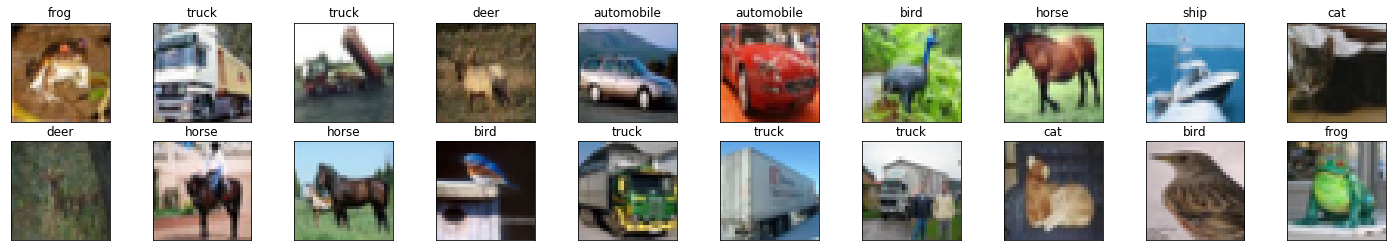

In [20]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [45]:
import torch.nn as nn
import torch.nn.functional as F

#Define CNN structure
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        #Convolutional layer (32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        #convolutional layer (16x16x16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #convolutional layer (8x8x32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64*4*4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500,10)
        #dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.20)
        
    def forward(self,x):
        #Adding sequence of convolution and max pooling layers
        
        # (32x32x3 image tensor)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # (16x16x16 image tensor)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # (8x8x32 image tensor)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # (4x4x64 image tensor)
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
    
        x = self.dropout(x)
        #First hidden layer with relu activation function
        x = F.relu(self.fc1(x))    
        #add 1st dropout layer
        x = self.dropout(x)
        #add 2nd hidden layer
        x = self.fc2(x)
        
        return x
    
#Complete CNN
model = Net()
print(model)

#move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [46]:
# Define loss and optimizer 
import torch.optim as optim

#specify loss function
criterion = nn.CrossEntropyLoss()

#specify optimizer
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [51]:
#number of epochs to train the model
n_epochs = 40

train_loss_store = []
valid_loss_store = []

for epoch in range(1,n_epochs+1):
    
    #keep track of training and validation
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0
    
    #Training of Model
    model.train()
    for data, target in train_loader:
        #move tensor to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        #clear the gradient of all optimized variables
        optimizer.zero_grad()
        #forward pass compute predicted output
        output = model(data)
        #calculate the batch loss
        loss = criterion(output, target)
        #backward pass compute the gradient of loss with respect to model parameter
        loss.backward()
        #perform optimizer step
        optimizer.step()
        #update training loss
        train_loss += loss.item()*data.size(0)
        
    #Validate the model
    model.eval()
    for data, target in valid_loader:
        #move tensor to GPU if CUDA is available
#         print(target.shape)
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        #forward pass compute output by passing through optimized model
        output = model(data)
        #print(output.shape)
        #batch loss calculation
        loss = criterion(output,target)
        
        #checking correct classes
        top_p, top_class = output.topk(1, dim=1)
        #find number of correct classes predicted
        top_p, top_class = output.topk(1, dim=1)
        #print(top_class)
        for i in range(batch_size):
            if target[i] == top_class[i]:
                correct += 1 
                
        #update validation loss
        valid_loss += loss.item()*data.size(0)
        
    #calculation of average losses
    train_loss = train_loss/(len(train_loader.dataset))
    valid_loss = valid_loss/(len(valid_loader.dataset))
    accuracy = correct/(len(valid_loader.dataset))
    
    train_loss_store.append(train_loss)
    valid_loss_store.append(valid_loss)
    
    
    if epoch == 40:
        torch.save(model.state_dict(), 'model_cifar.pt')
        
    
    print("Epoch:{} \t Train_loss: {:.6f} \t Valid_loss: {:.6f} \t Accuracy: {:.6f}".format(epoch, train_loss,valid_loss, accuracy))
        
    #plt.plot(train_loss_store, label='Training loss')
    #plt.plot(valid_loss_store, label='Validation loss')
    #plt.legend(frameon=False)
    #plt.savefig('final.png', dpi=100)
    #plt.show()

Epoch:1 	 Train_loss: 0.246639 	 Valid_loss: 0.867295 	 Accuracy: 0.755200
Epoch:2 	 Train_loss: 0.243700 	 Valid_loss: 0.846033 	 Accuracy: 0.753600
Epoch:3 	 Train_loss: 0.232110 	 Valid_loss: 0.866753 	 Accuracy: 0.755700
Epoch:4 	 Train_loss: 0.221321 	 Valid_loss: 0.891010 	 Accuracy: 0.750000
Epoch:5 	 Train_loss: 0.210456 	 Valid_loss: 0.877047 	 Accuracy: 0.756000
Epoch:6 	 Train_loss: 0.207468 	 Valid_loss: 0.889062 	 Accuracy: 0.755000
Epoch:7 	 Train_loss: 0.200165 	 Valid_loss: 0.903899 	 Accuracy: 0.754700
Epoch:8 	 Train_loss: 0.199189 	 Valid_loss: 0.902566 	 Accuracy: 0.756100
Epoch:9 	 Train_loss: 0.192242 	 Valid_loss: 0.913392 	 Accuracy: 0.755200
Epoch:10 	 Train_loss: 0.180353 	 Valid_loss: 0.951013 	 Accuracy: 0.750100
Epoch:11 	 Train_loss: 0.181157 	 Valid_loss: 0.923440 	 Accuracy: 0.751100
Epoch:12 	 Train_loss: 0.175217 	 Valid_loss: 0.911328 	 Accuracy: 0.753300
Epoch:13 	 Train_loss: 0.173309 	 Valid_loss: 0.956639 	 Accuracy: 0.752700
Epoch:14 	 Train_loss

In [1]:
plt.plot(train_loss_store, label='Training loss')
plt.plot(valid_loss_store, label='Validation loss')
plt.legend(frameon=False)
#plt.savefig('final.png', dpi=100)
plt.show()

NameError: name 'plt' is not defined